In [112]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

$$P(t,T) = \exp{\left( -(T-t)R(T-t, r(t)) \right)}$$
$$R(\theta, r) = R_{\infty} - \frac{1}{a \theta} \left( (R_{\infty} - r)(1-e^{-a \theta}) - \frac{\sigma^2}{4 a^2} \left( 1- e^{-a \theta} \right)^2 \right)$$
$$R_{\infty} = b^* - \frac{\sigma^2}{2a^2} \ \ \ b^* = b-\lambda\sigma/a$$

- $\bar{T}$ : limite de temps
- $T$ : échance de l'obligation sur coupon
- $\theta$ : échéance du call
- $t$ : instant présent

In [113]:
def simulate_taux_court(r0, a, b, sigma, T_bar, N):
    """
    Simulates the short rate between time 0 and T_bar using the Vasicek model.

    Parameters:
        r0 (float): Initial short rate at time 0.
        a (float): Speed of mean reversion.
        b (float): Long-term mean level.
        sigma (float): Volatility of the short rate.
        T_bar (float): Time horizon of the simulation.
        N (int): Number of time steps.

    Returns:
        numpy.ndarray: Simulated short rate path over N time steps.
    """
    dt = T_bar / N
    r = np.zeros(N)
    r[0] = r0
    for i in range(1, N):
        r[i] = r[i-1] + a * (b - r[i-1]) * dt + sigma * np.sqrt(dt) * np.random.randn()
    return r


In [114]:
def R(theta, r, lam, a, b, sigma):
    b_star = b - lam*sigma/a
    R_inf = b_star - sigma**2/(2*a**2)
    res = (R_inf-r)*(1-np.exp(-a*theta))
    res += -(sigma*2/(4*a**2))*(1-np.exp(-a*theta))**2
    res = -res/(a*theta)
    res += R_inf
    return res

def P(idx_T, T_bar, N, a, b, sigma, lam, r):
    """
    Returns the zero-coupon bond prices between time 0 and T 
    for a bond maturing at time T, based on a simulated short rate path.

    Parameters:
        idx_T (int): Index corresponding to maturity T in the time grid.
        T (float): Maturity of the zero-coupon bond.
        T_bar (float): Total simulation horizon.
        N (int): Number of time steps in the simulation.
        r0 (float): Initial short rate.
        a (float): Speed of mean reversion in the Vasicek model.
        b (float): Long-term mean level of the short rate.
        sigma (float): Volatility of the short rate.

    Returns:
        numpy.ndarray: Array of zero-coupon bond prices from 0 to T.
    """
    T = idx_T*T_bar/N
    P = np.zeros(idx_T)
    dt = T_bar / N
    for i in range(idx_T):
        t = i * dt
        P[i] = np.exp(-(T - t) * R(T - t, r[i], lam, a, b, sigma))
    return P

In [137]:
r0 = 0.02
a = 0.5
b = 0.03
sigma = 0.2
T_bar = 5.0
N = int(252 * T_bar)
lam = 0.1

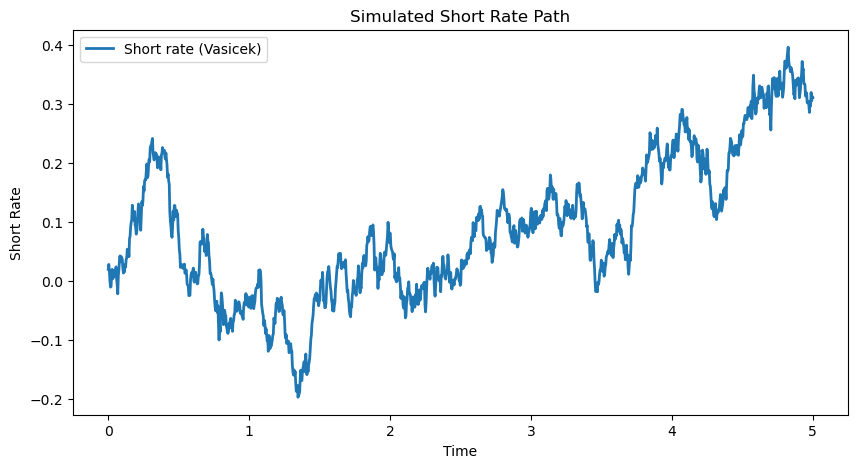

In [138]:
# Simulation du taux court
r = simulate_taux_court(r0, a, b, sigma, T_bar, N)
t = np.linspace(0, T_bar, N)  # axe du temps

# Tracé
plt.figure(figsize=(10, 5))
plt.plot(t, r, label='Short rate (Vasicek)', linewidth=2)
plt.title('Simulated Short Rate Path')
plt.xlabel('Time')
plt.ylabel('Short Rate')
plt.legend()
plt.show()

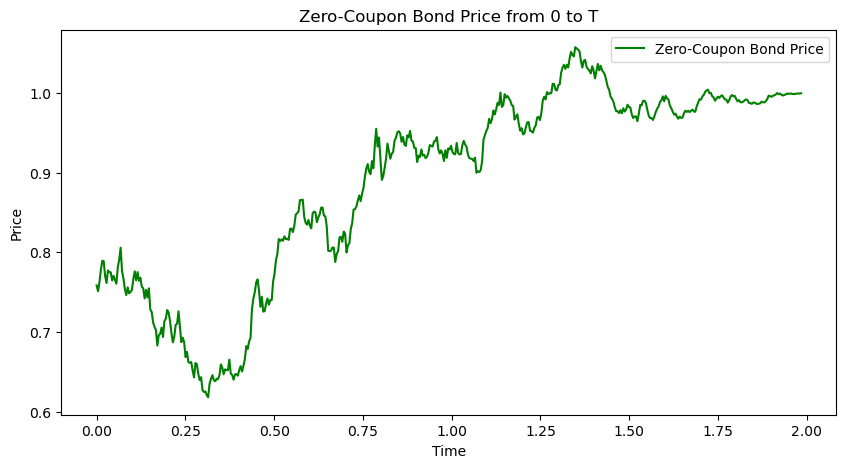

In [139]:
idx_T = 500
T = idx_T * T_bar / N  # correspondance avec la fonction

# Calcul des prix
P_vals = P(idx_T, T_bar, N, a, b, sigma, lam, r)

# Tracé
time_grid = np.linspace(0, T, idx_T)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, P_vals, label='Zero-Coupon Bond Price', color='green')
plt.title('Zero-Coupon Bond Price from 0 to T')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

$$C_t^{\theta} = B(t, P^{\theta} (t,T)) \ \ \ \ P^{\theta} (t, x) = \frac{P(t, T)}{P(t, \theta)}$$
$$B(t, x) = xN(d_1 (t, x)) - KN(d_2 (t, x)) \ \ \ \ \ N(x) = \int_{- \infty}^{+ \infty} \frac{e^{-x^2/2}}{\sqrt{2 \pi}} dx$$

In [140]:
def volatility(t, T, a, sigma):
    return -sigma * (1 - np.exp(-a * (T - t))) / a

def integrated_volatility(t, T, a, theta, sigma):
    res = (1 - np.exp(-a * (T - theta)))**2 * (1 - np.exp(-2 * a * (theta - t)))
    res = sigma**2 * res / (2 * a**3)
    return np.sqrt(res)

def d1(t, x, K, theta, a, T, sigma):
    sig = integrated_volatility(t, T, a, theta, sigma)
    return (np.log(x / K) + 0.5 * sig**2) / sig

def d2(t, x, K, theta, a, T, sigma):
    sig = integrated_volatility(t, T, a, theta, sigma)
    return d1(t, x, K, theta, a, T, sigma) - sig

def B(t, x, K, theta, a, T, sigma):
    return x * norm.cdf(d1(t, x, K, theta, a, T, sigma)) - K * norm.cdf(d2(t, x, K, theta, a, T, sigma))

def option_price(idx_theta, idx_T, T_bar, N, K, theta, a, b, sigma, lam, r):
    """
    Computes the theta forward price of a European call option on a zero-coupon bond 
    under the Vasicek model.

    Parameters:
        idx_theta (int): Index for option maturity (θ).
        idx_T (int): Index for bond maturity (T).
        T_bar (float): Total time horizon.
        N (int): Number of time steps.
        K (float): Strike price of the option.
        theta (float): Option maturity.
        a, b, sigma, lam (float): Vasicek model parameters.
        r (np.ndarray): Simulated short rate path.

    Returns:
        np.ndarray: Option prices up to time θ.
    """
    prices = np.zeros(idx_theta)
    P_T = P(idx_T, T_bar, N, a, b, sigma, lam, r)
    P_theta = P(idx_theta, T_bar, N, a, b, sigma, lam, r)
    T = idx_T * T_bar / N
    for i in range(idx_theta):
        t = i * T_bar / N
        x = P_T[i] / P_theta[i]
        prices[i] = B(t, x, K, theta, a, T, sigma)
    return prices

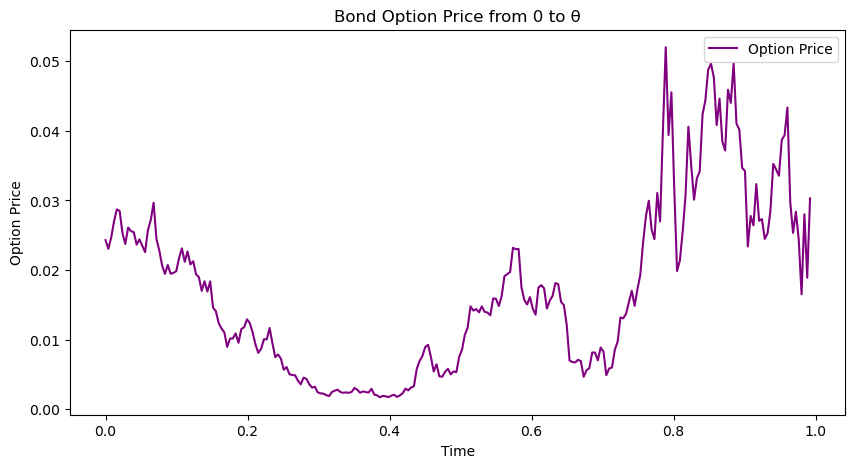

In [141]:
idx_theta = 250
K = 0.9
theta = idx_theta * T_bar / N

# Calcul des prix
prices = option_price(idx_theta, idx_T, T_bar, N, K, theta, a, b, sigma, lam, r)

# Tracé
time_grid = np.linspace(0, theta, idx_theta)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, prices, label='Option Price', color='purple')
plt.title('Bond Option Price from 0 to θ')
plt.xlabel('Time')
plt.ylabel('Option Price')
plt.legend()
plt.show()

### Stratégie de couverture

Pour $0 \leq \theta \leq T \leq \bar{T}$ :
- $H^T_t$ : quantité d'obligations zéro-coupon d'échéance $T$ à détenir
- $H^{\theta}_t$ : quantité d'obligations zéro-coupon d'échéance $\theta$ à détenir

$$H^T_t = N(d_1 (t, P^{\theta}(t, T))), \ \ \ \ H^{\theta}_t = -KN(d_2(t, P^{\theta} (t, T)))$$

In [142]:
def H(idx_theta, K, theta, a, b, idx_T, sigma, T_bar, N, lam, r):
    H1 = np.zeros(idx_theta)
    H2 = np.zeros(idx_theta)

    T = idx_T * T_bar / N

    P_T = P(idx_T, T_bar, N, a, b, sigma, lam, r)
    P_theta = P(idx_theta, T_bar, N, a, b, sigma, lam, r)
    
    for i in range(idx_theta):
        t = i * T_bar / N
        x = P_T[i]/P_theta[i]
        H1[i] = norm.cdf(d1(t, x, K, theta, a, T, sigma))
        H2[i] = -K * norm.cdf(d2(t, x, K, theta, a, T, sigma))

    return (H1, H2)

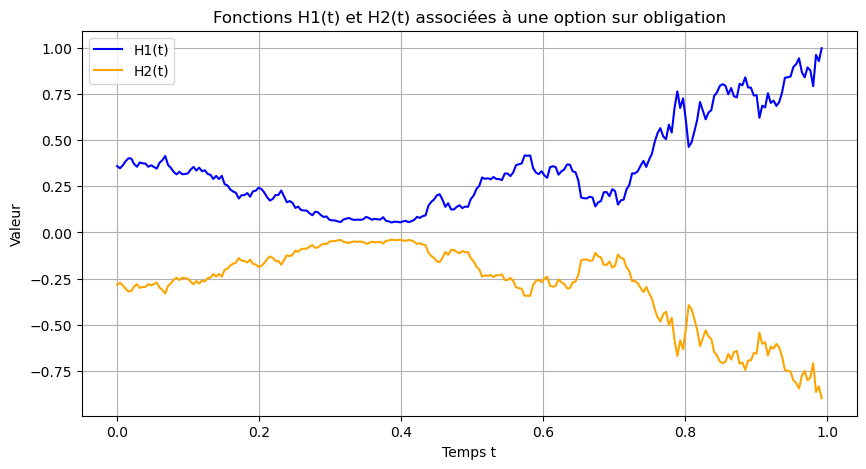

In [143]:
# Calcul de H1 et H2
H1_vals, H2_vals = H(idx_theta, K, theta, a, b, idx_T, sigma, T_bar, N, lam, r)

# Grille de temps pour H1 et H2
time_theta = np.linspace(0, theta, idx_theta)

# Tracé
plt.figure(figsize=(10, 5))
plt.plot(time_theta, H1_vals, label='H1(t)', color='blue')
plt.plot(time_theta, H2_vals, label='H2(t)', color='orange')
plt.title('Fonctions H1(t) et H2(t) associées à une option sur obligation')
plt.xlabel('Temps t')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

In [144]:
def portfolio_value(H1, H2, idx_theta, idx_T, T_bar, N, a, b, sigma, lam, r):
    """
    Computes the value of the hedging portfolio at each time step t_i.

    Parameters:
        H1, H2 : np.ndarray
            Arrays of portfolio weights: H1 for ZC bonds maturing at T, H2 for ZC bonds maturing at θ.
        idx_theta, idx_T : int
            Indices corresponding to the option maturity θ and bond maturity T on the time grid.
        T_bar : float
            Total simulation horizon.
        N : int
            Number of time steps in the simulation.
        a, b, sigma, lam : float
            Vasicek model parameters (mean reversion, long-term mean, volatility, market price of risk).
        r : np.ndarray
            Simulated short rate path.

    Returns:
        np.ndarray : Portfolio value over time from t = 0 to θ.
    """
    portfolio = np.zeros(idx_theta)
    dt = T_bar / N  # Time step size

    for i in range(idx_theta):
        t = i * dt                  # Current time
        tau_T = (idx_T * dt) - t    # Time to maturity for bond T
        tau_theta = (idx_theta * dt) - t  # Time to maturity for bond θ
        r_t = r[i]                  # Short rate at time t

        # Compute zero-coupon bond prices at time t for maturities T and θ
        P_T = np.exp(-tau_T * R(tau_T, r_t, lam, a, b, sigma))
        P_theta = np.exp(-tau_theta * R(tau_theta, r_t, lam, a, b, sigma))

        # Compute portfolio value at time t
        portfolio[i] = H1[i] * P_T + H2[i] * P_theta

    return portfolio



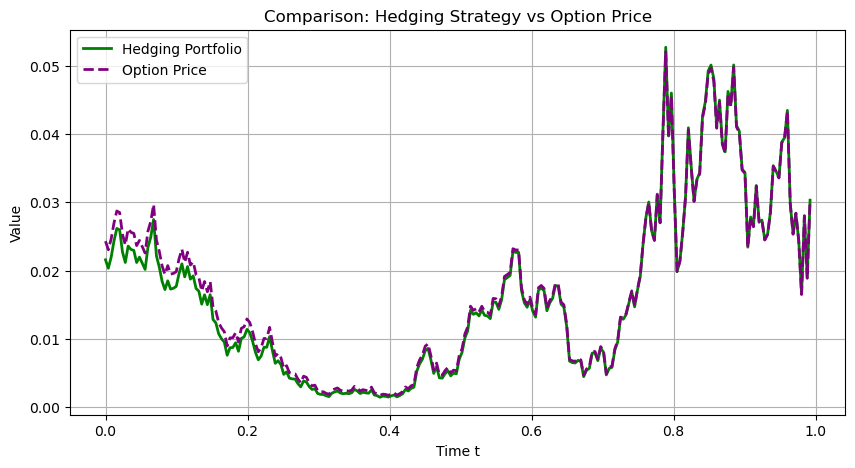

In [146]:
# Compute the value of the hedging portfolio over time
portfolio_vals = portfolio_value(H1_vals, H2_vals, idx_theta, idx_T, T_bar, N, a, b, sigma, lam, r)

# Compute the option price over time (already defined earlier)
option_vals = option_price(idx_theta, idx_T, T_bar, N, K, theta, a, b, sigma, lam, r)

# Time grid from 0 to θ
time_grid = np.linspace(0, theta, idx_theta)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(time_grid, portfolio_vals, label="Hedging Portfolio", linewidth=2, color="green")
plt.plot(time_grid, option_vals, label="Option Price", linewidth=2, linestyle='--', color="purple")
plt.title("Comparison: Hedging Strategy vs Option Price")
plt.xlabel("Time t")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()